## Should Asset Baskets help a predictive model?
The question that I'm trying to answer with this set of data exploration is whether different asset classes (ids) have very different predictive features. This is to gauge whether a model might benefit by splitting them into baskets of asset classes with similar correlative features.

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%matplotlib inline

In [3]:
with pd.HDFStore('train.h5','r') as train:
    df = train.get("train")

In [162]:
asset_class = df.groupby('id')
asset_class_count = asset_class.count()

In [5]:
def get_corr_by_feature(df,num_features=5,min_periods=40):
    columns = df.columns
    y_values = df[columns[-1]]
    features_corr = []
    for col in columns:
        if col != 'timestamp' and col != 'id' and col != "y":
            correlation = df[col].corr(y_values,min_periods = min_periods) ##min_periods helps make sure nothing is highly correlated just because there's so little data
            features_corr.append([col,correlation])
            
    features_series = pd.DataFrame(features_corr,columns = ['Features','Correlation to Y'])
    features_series = features_series.iloc[features_series['Correlation to Y'].abs().sort_values(ascending = False).index]
    return features_series[:num_features]

We shouldn't expect asset classes to share predictive features, so let's break them up. We could try to find consistently predictive features (which several posted kernels have done) or try to create separate models for separate asset classes. The first option sounds intuitively superior for a couple reasons (computationally, + more data, etc), but since lots of people have tried that already I figured I'd try my luck at the latter.

In [6]:
##Get the top 5 most correlated features by asset class
asset_class_predictors_full = asset_class.apply(get_corr_by_feature,num_features=df.shape[1],min_periods=1)


/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


## Using Frequency to Allocate Asset Classes to Baskets
The goal of this kernel is to find some way to basket the asset classes in a logical way. Let's explore and see if we can't come up with a meaningful solution.

### Heatmap for absolute feature correlation to y by ID
Before we get started on building our models, it might be useful just to visualize any features that seem to be consistent. Below, you can see that a few features do seem to be generally useful, which we might include in several of models. 

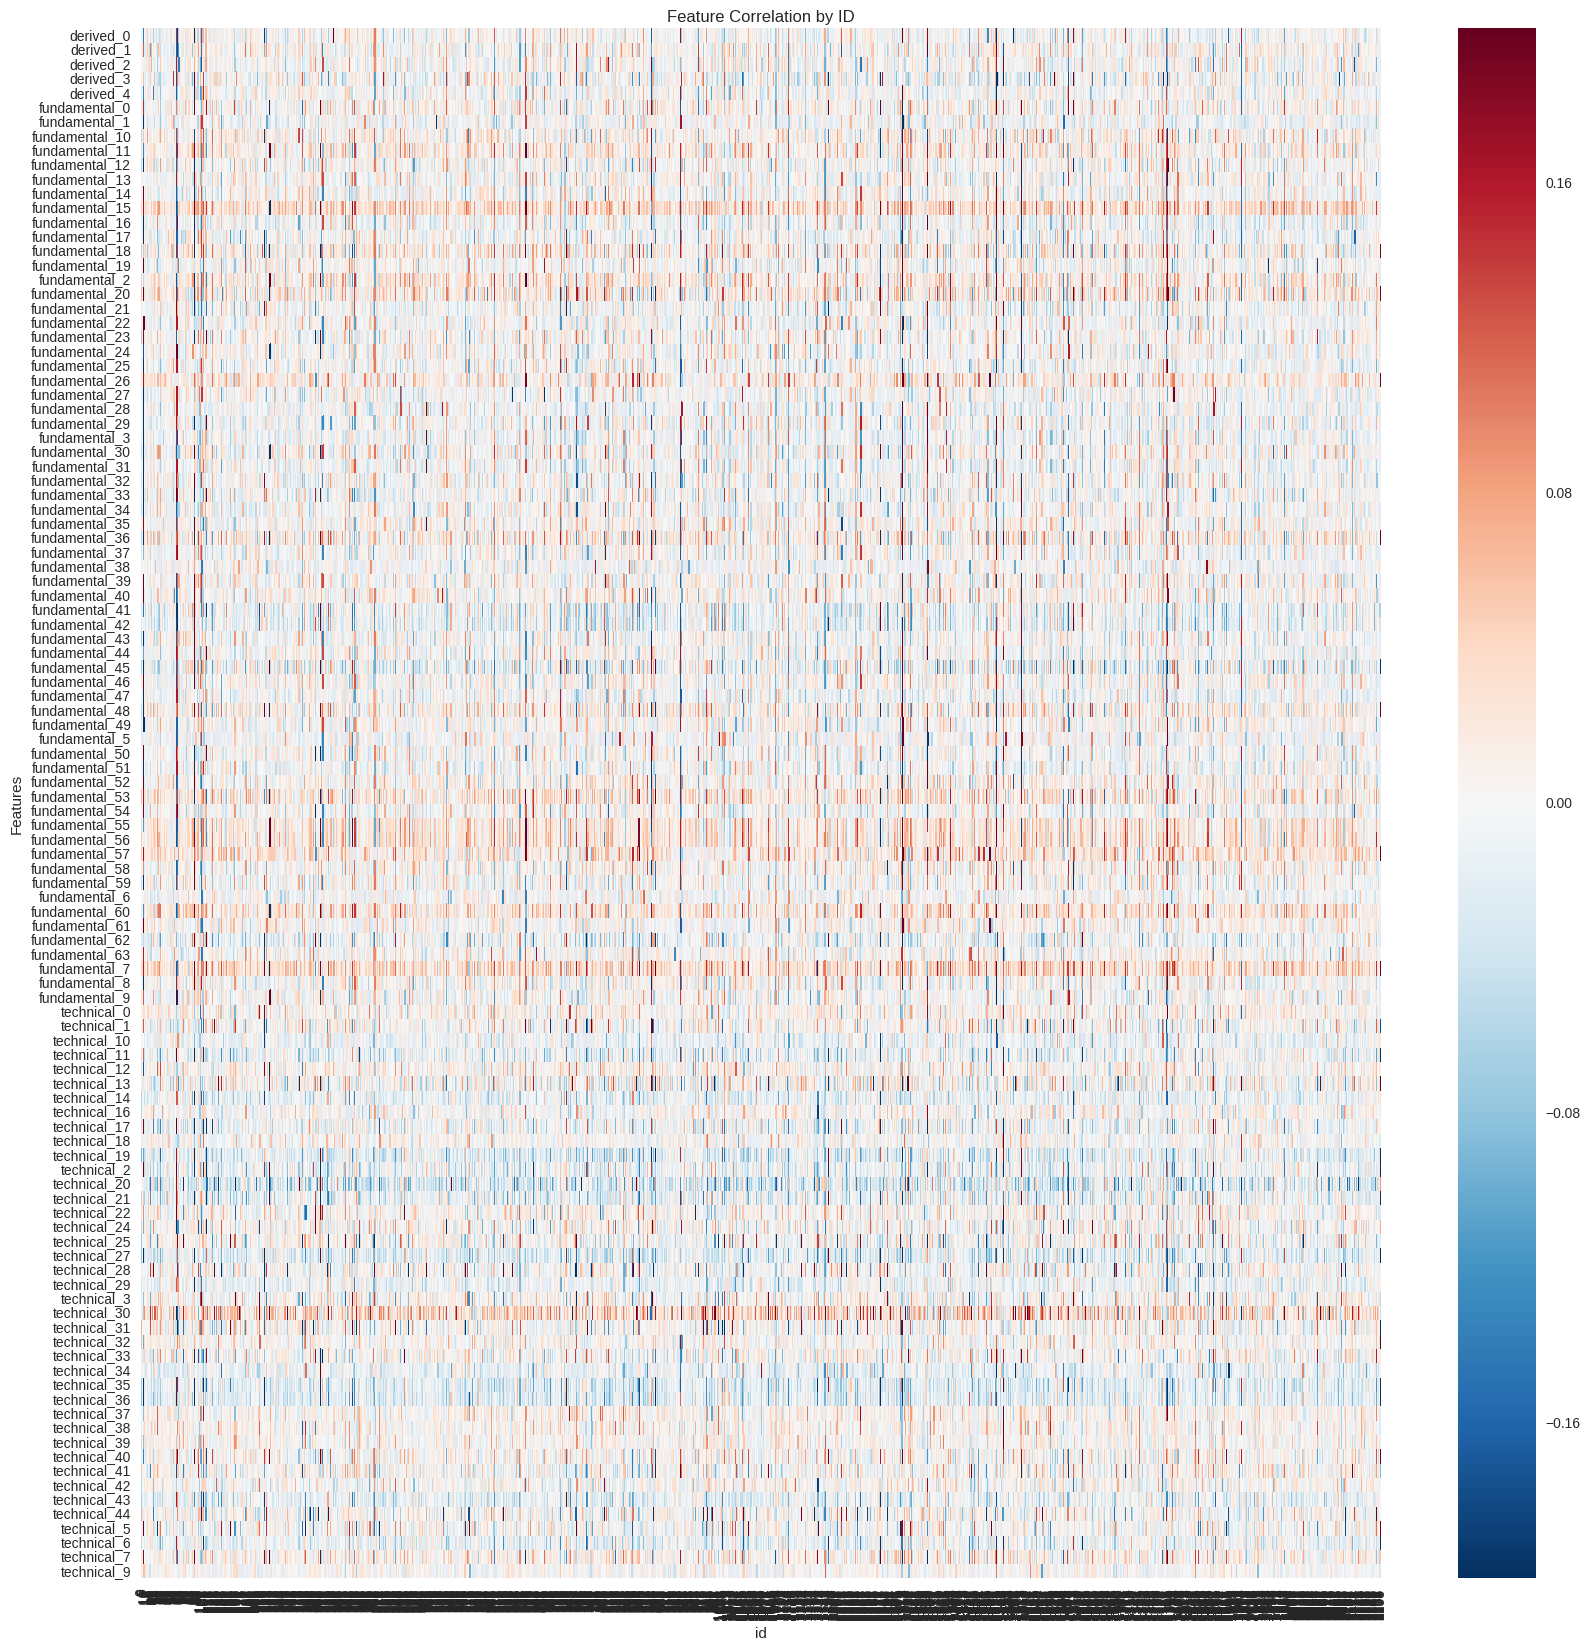

In [94]:
d = asset_class_predictors_full.reset_index().drop(['level_1'],1).sort_values(['id','Features'])
d_pivot = d.pivot(values='Correlation to Y',index='Features',columns='id')
fig = plt.figure(figsize=(20,20))
plt.title('Feature Correlation by ID')


sns.heatmap(d_pivot,vmax=0.2,vmin=-0.2)


It does look as though there are some generally strong features across all asset classes (Technical 30 sticks out).
It still looks like there may be a good deal of variation though. Let's continue on.

### Graphing frequency of feature appearance in top 5
Let's take a look at how many times a given feature is a top 5 predictor of y among asset classes.

In [203]:
num_features = 5 ##We will use the top X features
min_periods = 40 ##We may change later. Helps to protect against strong correlational bias because of a tiny amount of data
maximum_correlative_features_by_class = asset_class.apply(get_corr_by_feature,num_features=num_features,min_periods=min_periods)

Maximum possible value is: 1424


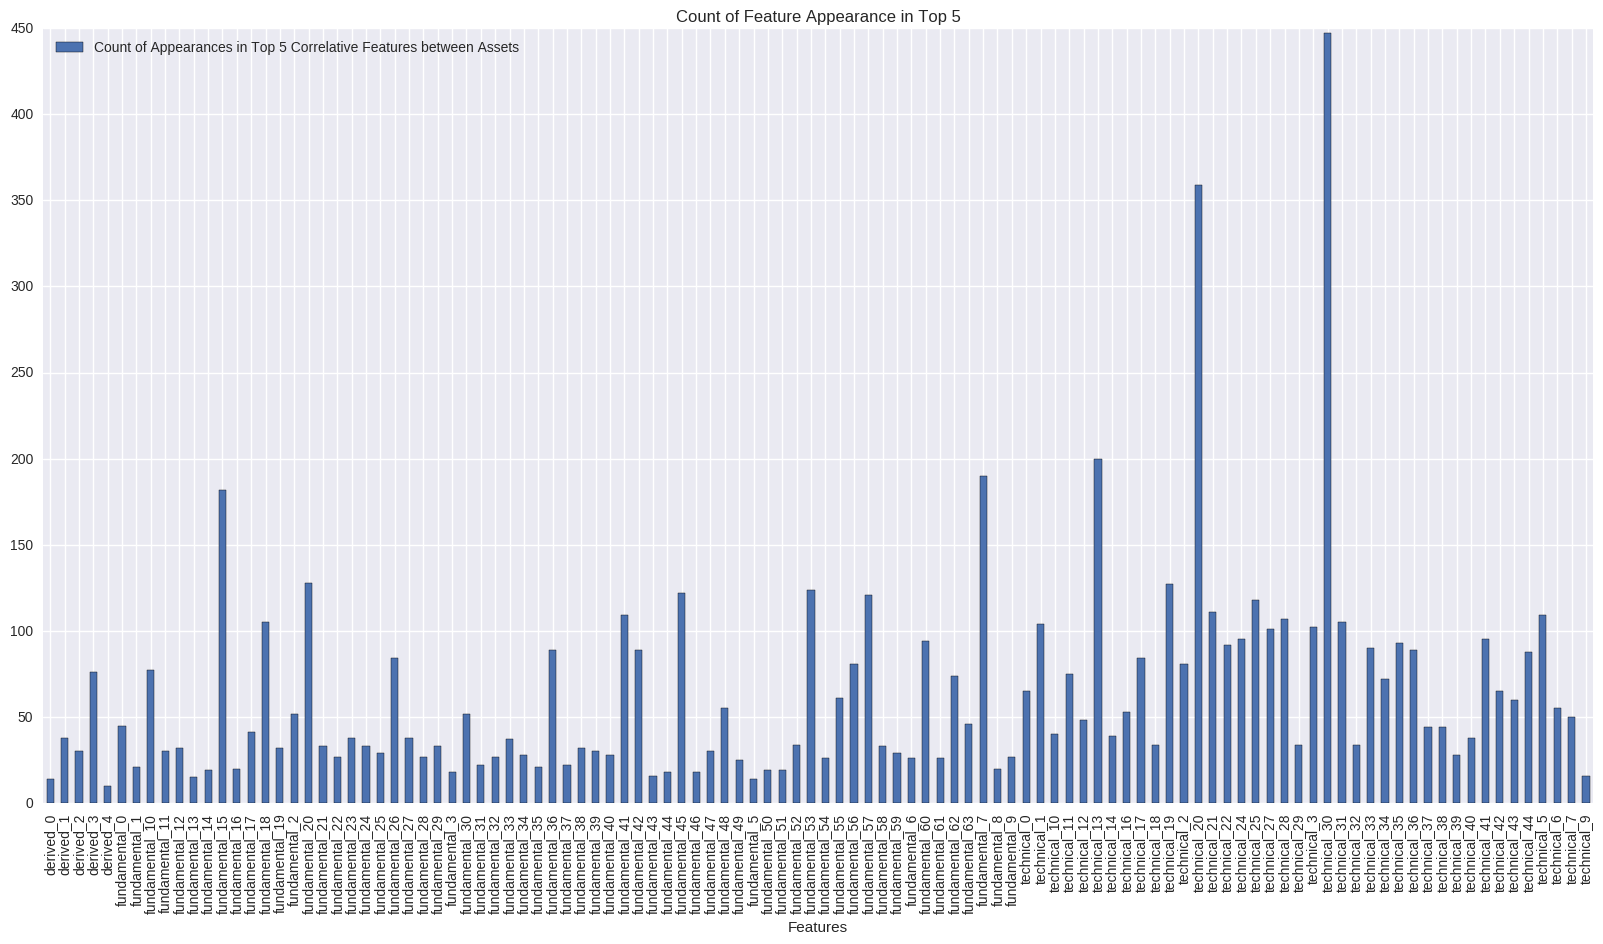

In [204]:
m = maximum_correlative_features_by_class
print("Maximum possible value is: {}".format(len(m.index.levels[0])))
feature_group = m.groupby('Features').count()
feature_group.columns=['Count of Appearances in Top {} Correlative Features between Assets'.format(num_features)]
feature_group.plot(title='Count of Feature Appearance in Top 5',kind='bar',figsize=(20,10))


In [194]:
top_5 = feature_group.sort_values('Count of Appearances in Top {} Correlative Features between Assets'.format(num_features),ascending=False).head()
top_5_features = top_5.index.values
top_5

,Count of Appearances in Top 5 Correlative Features between Assets
Features,
technical_30,447
technical_20,359
technical_13,200
fundamental_7,190
fundamental_15,182


It's pretty clear there are a few winners. Technical 30, technical 20, technical 13, fundamental 7 and fundamental 15 are most commonly in the top 5 for the best correlation score among asset classes.

Let's see what portion of the entire training data set is covered by assets that are relatively highly correlated (I.e in their top 5) with these 5 features.

In [236]:
asset_ids_found = []
for asset_id in m.index.levels[0]:
    for f in top_5_features:
        if (m.loc[asset_id]['Features'] == f).any():
            asset_ids_found.append(asset_id)

    

In [237]:
#Get the pct of correlated ids
total_asset_classes = len(m.index.levels[0])
correlated_ids_pct = float(len(asset_ids_found))/total_asset_classes

print ("% of IDs that contain at least one of the top 5 predictive features: {:.2f}".format(correlated_ids_pct*100))

#print ("% of Total Data (rows) that correspond to one of the found asset classed: {}".format())

% of IDs that contain at least one of the top 5 predictive features: 96.77


..That's actually a lot higher than I was expecting. It turns out that if you the top 5 most frequently highly correlated features, you can cover 97% of asset classes. 

In [238]:
#Let's see what the cumulative % is after adding each feature
labels = [1,2,3,4,5]
##This will hold all the asset classes with respect to what feature they were contained in.
cum_ids_found_at_level = [[],[],[],[],[]] ##Five positions
for asset_id in m.index.levels[0]:
    for i in range(len(top_5_features)):
        if (m.loc[asset_id]['Features'] == top_5_features[i]).any():
            cum_ids_found_at_level[i].append(asset_id)
            


In [239]:
cum_pcts_found_at_level = [float(len(x))/total_asset_classes for x in cum_ids_found_at_level]

ValueError: Argument dimensions are incompatible

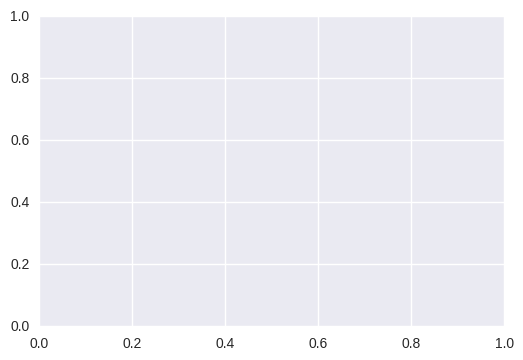

In [242]:
plt.stackplot([1],cum_pcts_found_at_level)

### Allocate Baskets Based on Rank

One way of allocating the baskets might be based on their top 5 correlative features. We can assign each feature a rank based on it's frequency of appearance, and then split the assets up based on whether that feature is seen in their top 5 predictors. 

I just want to note that this is **not** an optimal method... maybe not even a good one, and we'll do better stuff later. 

First we need to assign ranks.

In [122]:
feature_rank = {} ##A dictionary where the rank is the key,feature the value
feature_ranking_df = feature_group.copy() ##We will be mutating this, so we'll make a deep copy
count = 1

while not feature_ranking_df.empty:
    f = feature_ranking_df.idxmax().values[0] ##Get the label at the current maximum appearances
    feature_rank[count] = f
    
    feature_ranking_df.drop(f,inplace=True) ##Drop the current maximum
    count += 1

Now we can allocate assets to each basket based on common correlative features.
The following code should allocate approximately equal numbers of asset classes among the baskets, alon


First let's define a basket class to make things a little simpler

In [154]:
class Basket:
    
    def __init__(self):
        self._features = []
        self._asset_list = []
        
    def add_feature(self,feature):
        if feature not in self._features:
            self._features.append(feature)
        
    def add_asset(self,asset_id):
        if asset_id not in self._asset_list:
            self._asset_list.append(asset_id)
        
    def get_assets(self):
        return self._asset_list
    
    def get_features(self):
        return self._features
    
    def feature_size(self):
        return len(self._features)
    
    def size(self):
        return len(self._asset_list)

Now we'll allocate assets to baskets.
The idea here is that we want the baskets to be roughly uniform in size. We 

In [169]:
baskets = {}
unallocated_ids = m.index.levels[0].tolist()
n_baskets = 3
start_rank = 1
current_basket = 1

##Initialize baskets
for n in range(n_baskets):
    basket_name = n+1
    baskets[basket_name] = Basket()


current_rank = start_rank
data_lengths = np.zeros(n_baskets)
while unallocated_ids != [] and current_rank < 109:
    for asset_id in unallocated_ids:
        
        current_feature = feature_rank[current_rank]
        if (m.loc[asset_id]['Features'] == current_feature).any():
            baskets[current_basket].add_asset(asset_id)
            baskets[current_basket].add_feature(current_feature)
            unallocated_ids.remove(asset_id)
            rows_added = asset_class_count.loc[asset_id]['timestamp']
            data_lengths[current_basket-1] += rows_added
            print('Rows added at {}: {}'.format(asset_id,rows_added))
            
    current_rank += 1
    current_basket = basket_lengths.argmin() + 1
        
    



Rows added at 7: 1543
Rows added at 11: 1813
Rows added at 14: 218
Rows added at 18: 218
Rows added at 20: 1646
Rows added at 24: 932
Rows added at 26: 1813
Rows added at 38: 1813
Rows added at 49: 1711
Rows added at 56: 320
Rows added at 62: 62
Rows added at 65: 1442
Rows added at 72: 167
Rows added at 80: 1813
Rows added at 87: 1813
Rows added at 91: 377
Rows added at 113: 1813
Rows added at 118: 1813
Rows added at 126: 1524
Rows added at 129: 683
Rows added at 132: 1813
Rows added at 134: 218
Rows added at 140: 1813
Rows added at 142: 1813
Rows added at 152: 1813
Rows added at 159: 829
Rows added at 163: 523
Rows added at 171: 1758
Rows added at 174: 422
Rows added at 187: 1813
Rows added at 203: 1813
Rows added at 206: 1813
Rows added at 214: 136
Rows added at 217: 1813
Rows added at 223: 1813
Rows added at 229: 1813
Rows added at 232: 1813
Rows added at 235: 1813
Rows added at 249: 1813
Rows added at 255: 1813
Rows added at 258: 218
Rows added at 262: 1813
Rows added at 268: 1813


In [170]:
for v in baskets.values():
    print ('Basket size: ' + str(v.feature_size()))

Basket size: 1
Basket size: 0
Basket size: 67


In [164]:
asset_class_count.loc[0]['timestamp']

1646